In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

project_path = os.path.abspath('..')
if project_path not in sys.path:
    sys.path.append(project_path)

from MieSppForce.simulation import SimulationConfig, SweepRunner, Visualizer, DipoleCalculator, OpticalForceCalculator

from MieSppForce.simulation import CylindricalGrid, FieldsCalculator

import numpy as np
from pint import UnitRegistry
ureg = UnitRegistry()


base_config = SimulationConfig(
    wl =600 * ureg.nanometer,
    R =  295/2* ureg.nanometer,
    dist = 2 * ureg.nanometer,
    angle = np.deg2rad(25),
    a_angle = 0,
    phase= 0
)

grid = CylindricalGrid(
    r=np.array([2000]) * ureg.nm,
    phi=np.linspace(0, 2*np.pi, 200) * ureg.radian,
    z=np.array([0.0]) * ureg.nm
)

In [ ]:
sweep_res, fields_sweep = SweepRunner(base_config, 'wl', np.arange(600,1201,6) * ureg.nm, True, True, True, grid).run()



In [16]:
setattr(base_config, 'a_angle', np.pi/4)
setattr(base_config, 'phase', -np.pi/2)

In [4]:
Q_=ureg.Quantity

In [18]:
px= sweep_res['px'].apply(lambda x: x.to('C*m').magnitude).to_numpy()
py = sweep_res['py'].apply(lambda x: x.to('C*m').magnitude).to_numpy()
pz = sweep_res['pz'].apply(lambda x: x.to('C*m').magnitude).to_numpy()

mx = sweep_res['mx'].apply(lambda x: x.to('A*m**2').magnitude).to_numpy()
my = sweep_res['my'].apply(lambda x: x.to('A*m**2').magnitude).to_numpy()
mz = sweep_res['mz'].apply(lambda x: x.to('A*m**2').magnitude).to_numpy()

wls = sweep_res['wl'].apply(lambda x: x.to('nm').magnitude).to_numpy()

Fx= sweep_res['Fx'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fy = sweep_res['Fy'].apply(lambda x: x.to('N').magnitude).to_numpy()

Fxe0= sweep_res['Fxe0'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fye0 = sweep_res['Fye0'].apply(lambda x: x.to('N').magnitude).to_numpy()

Fxm0= sweep_res['Fxm0'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fym0 = sweep_res['Fym0'].apply(lambda x: x.to('N').magnitude).to_numpy()

Fxe1= sweep_res['Fxe1'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fye1 = sweep_res['Fye1'].apply(lambda x: x.to('N').magnitude).to_numpy()

Fxm1= sweep_res['Fxm1'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fym1 = sweep_res['Fym1'].apply(lambda x: x.to('N').magnitude).to_numpy()

Fxm2= sweep_res['Fxm2'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fym2 = sweep_res['Fym2'].apply(lambda x: x.to('N').magnitude).to_numpy()

Fxe2= sweep_res['Fxe2'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fye2 = sweep_res['Fye2'].apply(lambda x: x.to('N').magnitude).to_numpy()

Fxcross= sweep_res['Fxcross'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fycross = sweep_res['Fycross'].apply(lambda x: x.to('N').magnitude).to_numpy()


Fxspp= sweep_res['Fxspp'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fyspp = sweep_res['Fyspp'].apply(lambda x: x.to('N').magnitude).to_numpy()


Fxsppe1= sweep_res['Fxsppe1'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fysppe1 = sweep_res['Fysppe1'].apply(lambda x: x.to('N').magnitude).to_numpy()

Fxsppm1= sweep_res['Fxsppm1'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fysppm1 = sweep_res['Fysppm1'].apply(lambda x: x.to('N').magnitude).to_numpy()

Fxsppm2= sweep_res['Fxsppm2'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fysppm2 = sweep_res['Fysppm2'].apply(lambda x: x.to('N').magnitude).to_numpy()

Fxsppe2= sweep_res['Fxsppe2'].apply(lambda x: x.to('N').magnitude).to_numpy()
Fysppe2 = sweep_res['Fysppe2'].apply(lambda x: x.to('N').magnitude).to_numpy()

In [19]:
c_const = 299792458
from scipy.integrate import quad
from MieSppForce import frenel

eps_Au = frenel.get_interpolate('Au')


def get_directivity(wl, P, M, eps_Au):
    px, py, pz = P
    mx, my, mz = M
    

    def I(phi): return np.abs((mx/c_const + np.sqrt(1/(eps_Au(wl).conj()+1))*py)*np.sin(phi) + (my/c_const - np.sqrt(1/(eps_Au(wl).conj()+1))*px)*np.cos(phi) - np.sqrt(eps_Au(wl)/(eps_Au(wl).conj()+1))*pz)**2
    Imax = quad(I, 0, 2 * np.pi)[0]
    return lambda phi: 2 * np.pi * I(phi) / Imax

wls = sweep_res['wl'].apply(lambda x: x.to('nm').magnitude).to_numpy()

phi = fields_sweep[Q_(wls[0],'nm')].df['phi'].apply(lambda x: x.to('rad').magnitude)


D = np.empty((len(wls), len(phi)))




for i in range(len(wls)):
    Di = get_directivity(wls[i], np.array([px[i], py[i], pz[i]]), np.array([mx[i], my[i], mz[i]]), eps_Au)
    for j in range(len(phi)):
        D[i,j] = Di(phi[j])


In [20]:
import pandas as pd
import numpy as np

# Загрузка данных
Hphi2_coms = pd.read_csv('spp_dir_tm.csv', header=None)

expected_wavelengths = np.arange(600, 1201, 6)
assert Hphi2_coms.shape[1] == 1 + len(expected_wavelengths), "Размерности не совпадают"

# Разделим данные: первый столбец — углы, остальные — значения
angles = Hphi2_coms.iloc[:, 0].values  # массив углов
data = Hphi2_coms.iloc[:, 1:].values   # значения для разных длин волн

# Создадим DataFrame, где индексы — углы, а столбцы — длины волн
Hphi2_comsol = pd.DataFrame(data, index=angles, columns=expected_wavelengths)
Hphi2_comsol.index.name = 'Angle'

In [21]:
phi_pyton = fields_sweep[Q_(wls[0], 'nm')].df['phi'].apply(lambda x: x.to('rad').magnitude)
phi_comsol = Hphi2_comsol[wls[0]].index.values

Hspp2_python = np.empty((len(wls), len(phi_pyton)))
Hspp2_comsol = np.empty((len(wls), len(phi_comsol)))

for i in range(len(wls)):
    fields_wl = fields_sweep[Q_(wls[i], 'nm')]

    Hspp2_python_i = fields_wl.df['Hphi_abs2'].apply(lambda x: x.to('A**2/m**2').magnitude)
    Hspp2_python_i_norm = Hspp2_python_i / np.sum(Hspp2_python_i)
    Hspp2_python_i_norm = Hspp2_python_i_norm / np.max(Hspp2_python_i_norm)
    

    HPhi2_comsol_i = Hphi2_comsol[wls[i]].values

    HPhi2_comsol_i_norm = HPhi2_comsol_i/np.sum(HPhi2_comsol_i)

    HPhi2_comsol_i_norm = HPhi2_comsol_i_norm/np.max(HPhi2_comsol_i_norm)
    
    Hspp2_python[i,:] = Hspp2_python_i_norm
    Hspp2_comsol[i,:] = HPhi2_comsol_i_norm
    

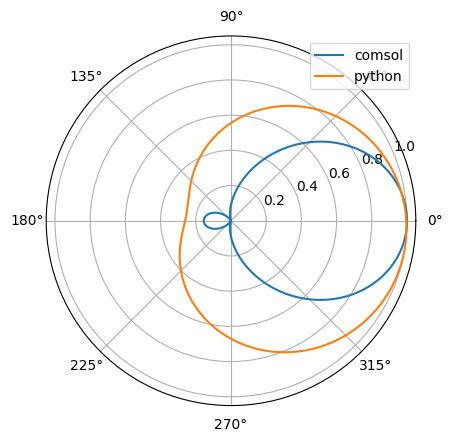

In [22]:
ind = 90


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.plot(phi_comsol, Hspp2_comsol[ind,:], label='comsol')
ax.plot(phi_pyton, Hspp2_python[ind,:], label='python')


ax.legend()

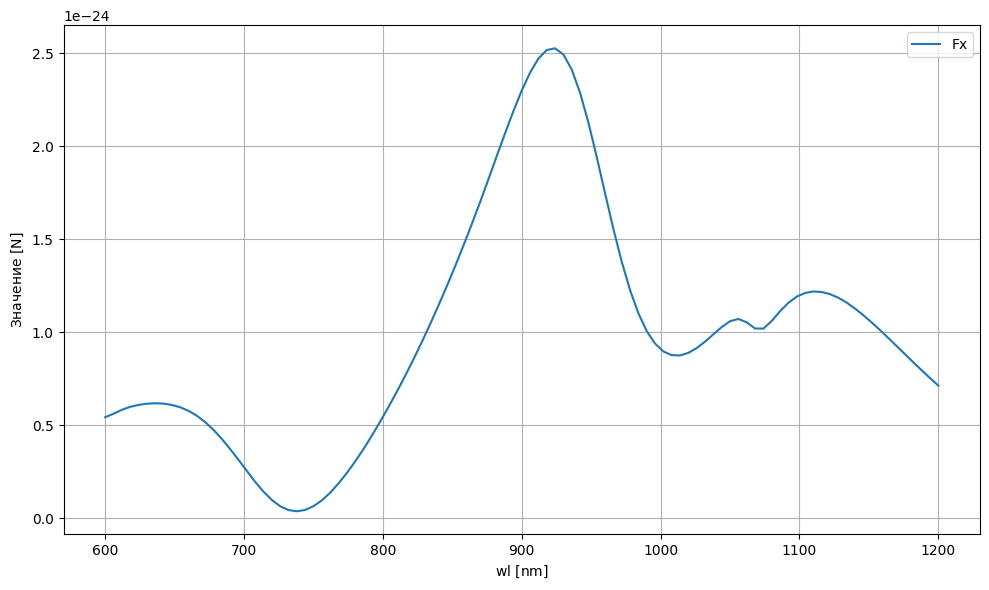

In [23]:
Visualizer.plot_components(sweep_res, 'wl', 'Fx')

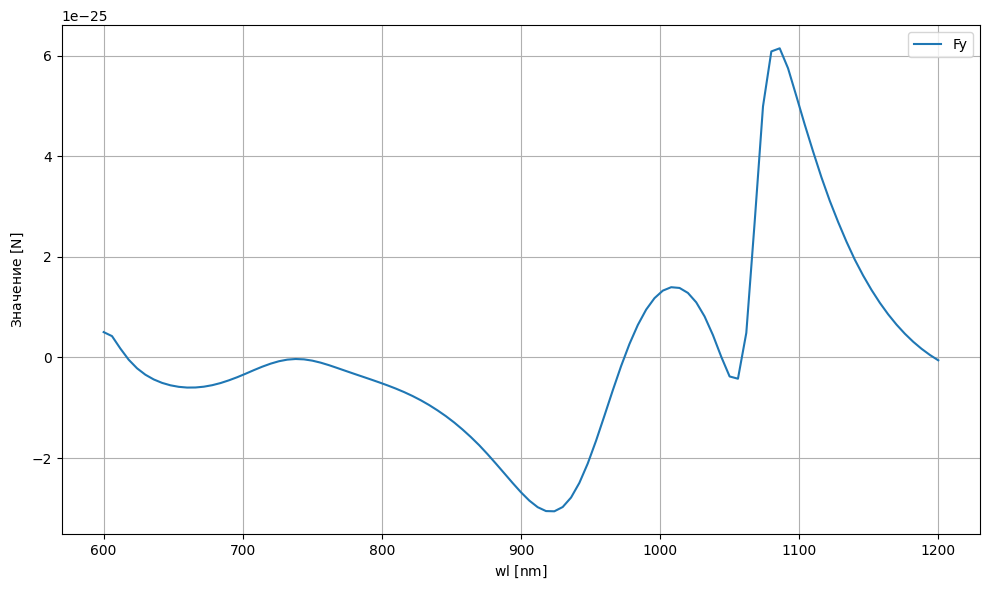

In [24]:
Visualizer.plot_components(sweep_res, 'wl', 'Fy')

In [25]:
  
phi_D_from_wl = np.empty(len(wls))

phi_Hspp2_comsol_from_wl = np.empty(len(wls))

phi_Hspp2_python_from_wl = np.empty(len(wls))

for i in range(len(wls)):
    j1 = np.argmax(D[i,:])
    j2 = np.argmax(Hspp2_comsol[i,:])
    j3 = np.argmax(Hspp2_python[i,:])
    
    phi_D_from_wl[i] = phi_pyton[j1]
    phi_Hspp2_comsol_from_wl[i] = phi_comsol[j2]
    phi_Hspp2_python_from_wl[i] = phi_pyton[j3]
    
    
angles_no_sc= np.unwrap(np.arctan2(Fyspp, Fxspp))

angles_no_sc = (angles_no_sc + 2 * np.pi) % (2 * np.pi)


phi_Hspp2_comsol_from_wl= np.unwrap(phi_Hspp2_comsol_from_wl)

phi_Hspp2_comsol_from_wl = (phi_Hspp2_comsol_from_wl + 2 * np.pi) % (2 * np.pi)


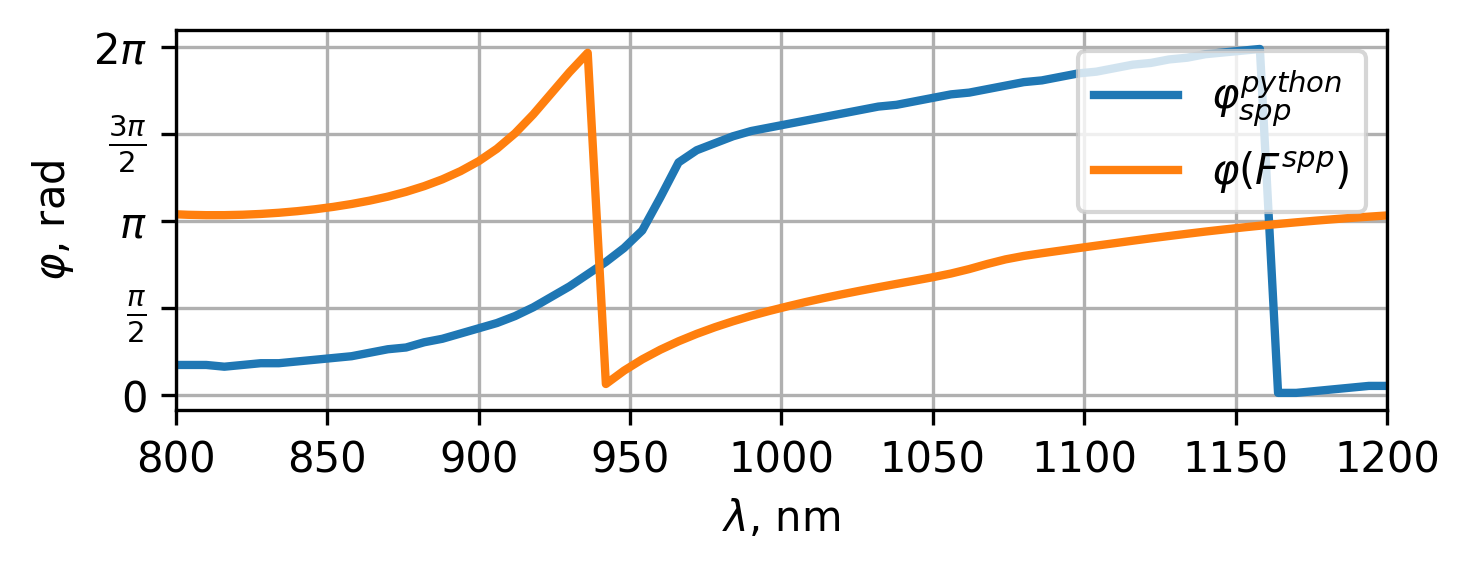

In [26]:
plt.figure(figsize=(5,2), dpi=300)

# plt.plot(wls, phi_D_from_wl, label=r'$\varphi_{spp}^D$', lw=2)

# plt.plot(wls, phi_Hspp2_comsol_from_wl, label=r'$\varphi_{spp}^{comsol}$', lw=2)

plt.plot(wls, phi_Hspp2_python_from_wl, label=r'$\varphi_{spp}^{python}$', lw=2)

#plt.plot(Rs, angles_no_sc_from_R, label=r'$\varphi (F^{no\;sc})$', lw=2, c='r')
plt.plot(wls, angles_no_sc, label=r'$\varphi (F^{spp})$', lw=2)

y_ticks = [0, np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
y_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
plt.grid()
plt.legend()

plt.yticks(y_ticks,y_ticklabels)
plt.xlim(800,wls[-1])
plt.ylabel('$\\varphi$, rad')
plt.xlabel('$\\lambda$, nm')
plt.tight_layout()
plt.savefig(f'spp_dir_vs_f_spp_from_wl_tm_onlypy.png', dpi=300)
plt.show()

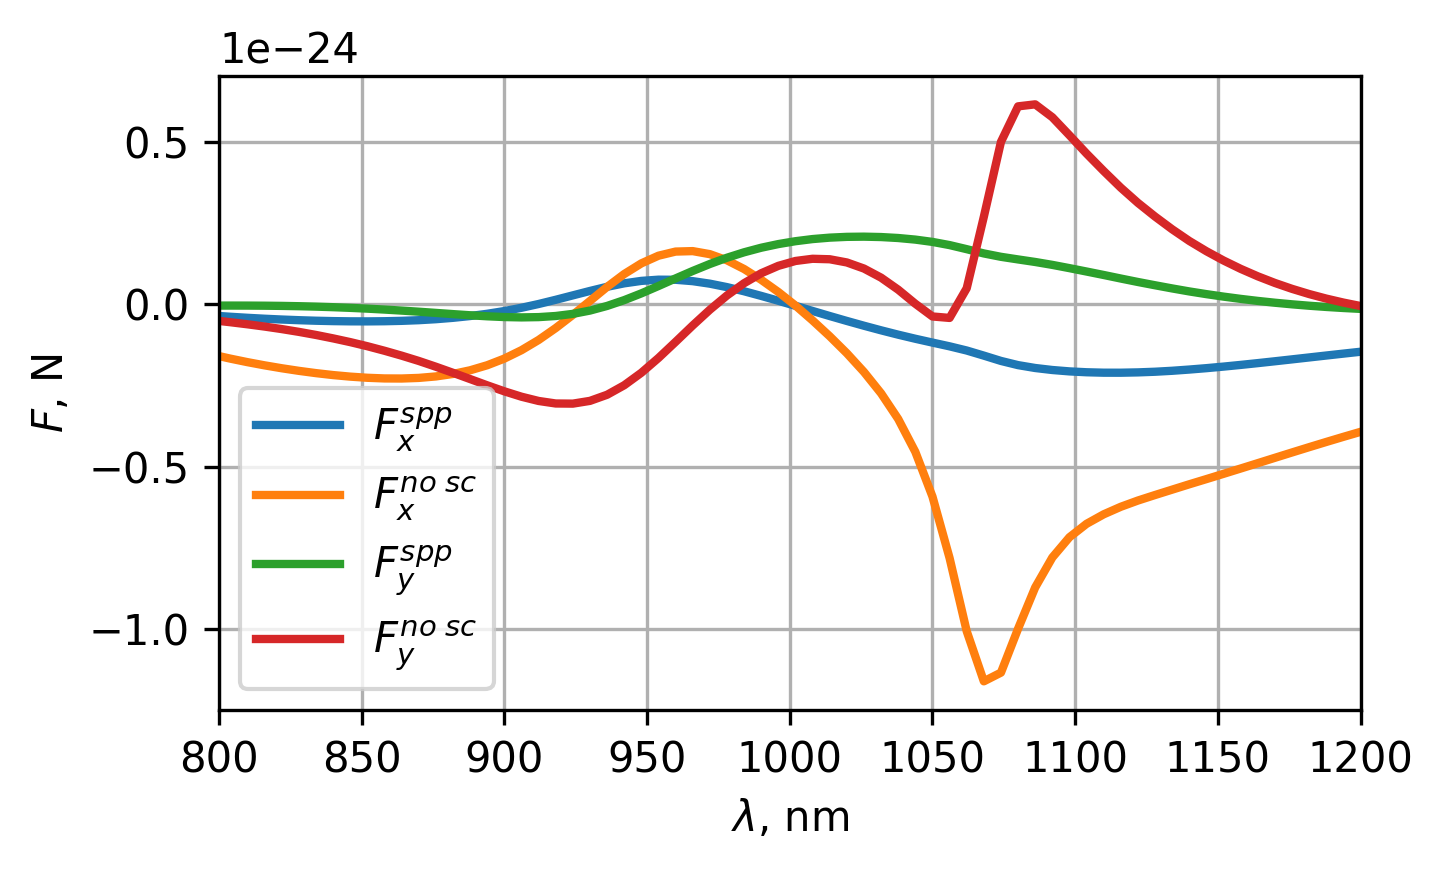

In [30]:
plt.figure(figsize=(5,3), dpi=300)

plt.plot(wls, Fxspp, label=r'$F_x^{spp}$', lw=2)
plt.plot(wls, Fx-Fxe0-Fxm0, label=r'$F_x^{no\;sc}$', lw=2)

plt.plot(wls, Fyspp, label=r'$F_y^{spp}$', lw=2)
plt.plot(wls, Fy-Fye0-Fym0, label=r'$F_y^{no\;sc}$', lw=2)


plt.grid()
plt.legend()

plt.xlim(800,wls[-1])
plt.ylabel('$F$, N')
plt.xlabel('$\\lambda$, nm')
plt.tight_layout()
#plt.savefig(f'fx_spp_vs_wlpng', dpi=300)
plt.show()


In [16]:
Hspp2_comsol.shape

(101, 1000)

(800.0, 1200.0)

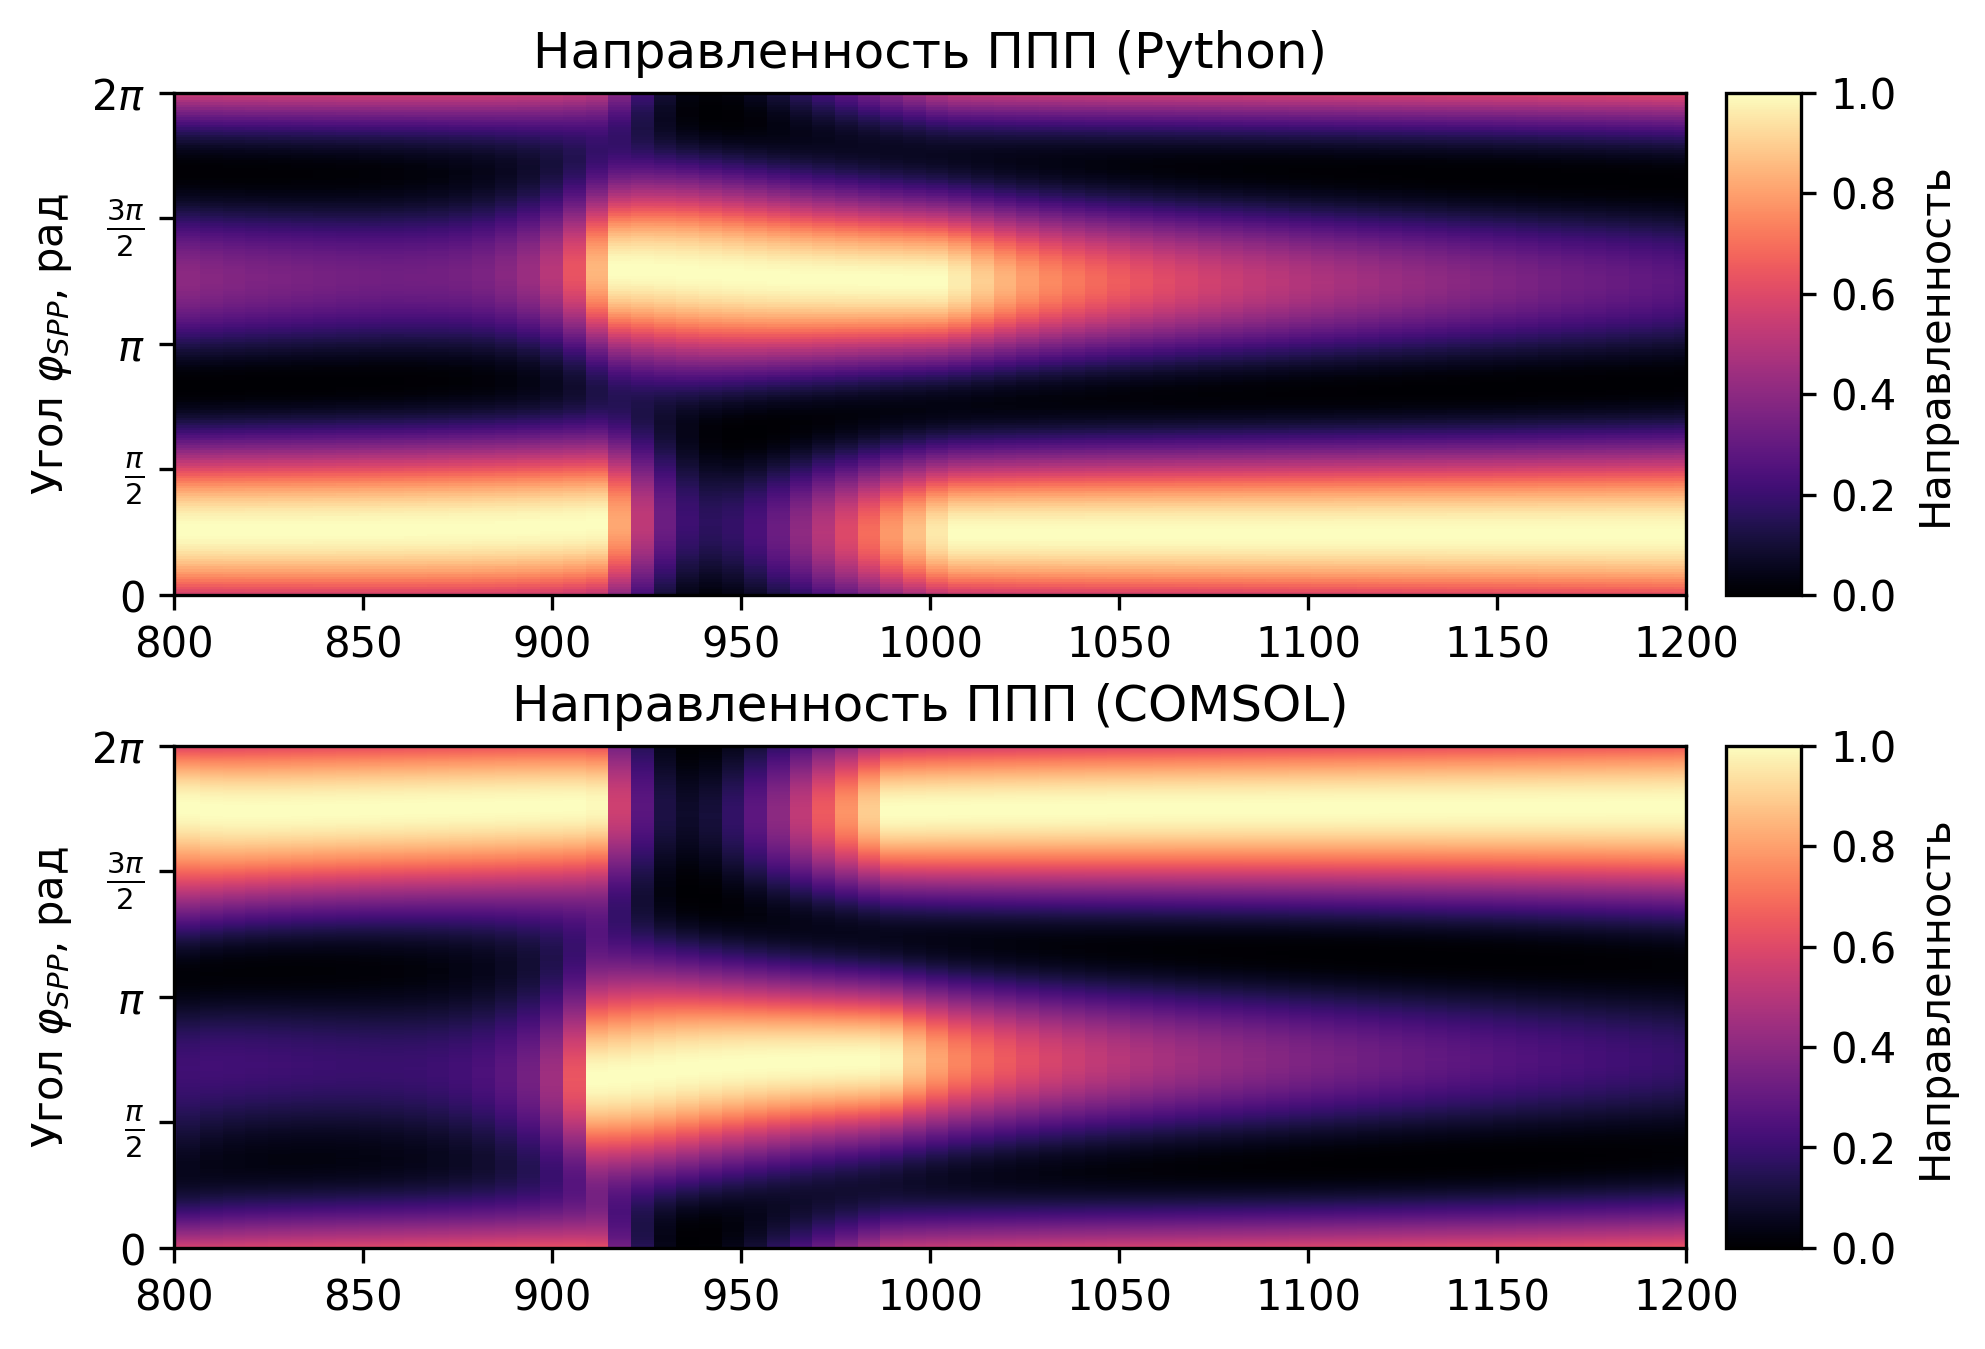

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np


# === Создание фигуры и макета ===
fig = plt.figure(figsize=(7, 5), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)

# === Верхний график (тепловая карта) ===
ax_top = fig.add_subplot(gs[0, 0])
directivity_map_python = ax_top.pcolor(wls, phi_pyton, Hspp2_python.T, cmap='magma', vmax=1, vmin=0)

# Настройка оси Y: метки углов в виде кратных π
y_ticks = [0, np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
y_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
# y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
# y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_top.set_yticks(y_ticks)
ax_top.set_yticklabels(y_ticklabels)

ax_top.set_ylim(0, 2*np.pi)
ax_top.set_ylabel(r'Угол $\varphi_{SPP}$, рад')
ax_top.set_title('Направленность ППП (Python)')

cax1 = fig.add_subplot(gs[0, 1])
fig.colorbar(directivity_map_python, cax=cax1, label='Направленность')



# === Верхний график (тепловая карта) ===
ax_bottom = fig.add_subplot(gs[1, 0])
directivity_map_comsol= ax_bottom.pcolor(wls, phi_comsol, Hspp2_comsol.T, cmap='magma', vmax=1, vmin=0)


ax_bottom.set_yticks(y_ticks)
ax_bottom.set_yticklabels(y_ticklabels)

ax_bottom.set_ylim(0, 2*np.pi)
ax_bottom.set_ylabel(r'Угол $\varphi_{SPP}$, рад')
ax_bottom.set_title('Направленность ППП (COMSOL)')

cax2 = fig.add_subplot(gs[1, 1])
fig.colorbar(directivity_map_comsol, cax=cax2, label='Направленность')
ax_bottom.set_xlim(800, wls[-1])
ax_top.set_xlim(800, wls[-1])

# angles_no_sc= np.arctan2(Fsppy[:,0], Fsppx[:,0])

# angles_no_sc = (angles_no_sc + 2 * np.pi) % (2 * np.pi)
# #angles_no_sc= np.unwrap(angles_no_sc)

# # Границы и метки оси Y

# ax_bottom.set_yticks(y_ticks)
# ax_bottom.set_yticklabels(y_ticklabels)
# ax_bottom.axhline(0, color='black', linestyle='-', linewidth=2)
# ax_bottom.axhline(2*np.pi, color='black', linestyle='-', linewidth=2)
# # closest_to_zero_idx = np.argmin(np.abs(angles_no_sc_from_R))
# # approx_zero_crossing_x = Rs[closest_to_zero_idx]
# # ax_bottom.axvline(approx_zero_crossing_x, color='black', linestyle='--', linewidth=2)
# ax_bottom.scatter(wls, angles_no_sc, label=r'$\varphi_F$', color='r', linewidth=1)
# ax_bottom.set_ylim(-1*np.pi/6, 13*np.pi/6)
# ax_bottom.set_xlim(wls[0], wls[-1])
# ax_bottom.set_xlabel('$\\lambda$, нм')
# ax_bottom.set_ylabel(r'Угол $\varphi_F$, рад')
# ax_bottom.grid(True)
# ax_bottom.legend()
#plt.savefig(f'spp_comsol_vs_spp_python.png', dpi=300)

